Changes from v2

- implemented the possiblity to add nodes to the system
- add new visualization based data frame

**Importing Dependencies**

In [1]:
# Imports
# Gymnasium imports
import gymnasium as gym 
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# Import helpers
import numpy as np
import pandas as pd
import random
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

from collections import deque

# Import stable baselines
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

from Environment.env_v5 import *
from Functions.visualization_functions import *

**Configuration of the Scenario**

In [2]:
# Configuration of the network
with open('./Config/network_config_v0.json') as file:
    network_config = file.read()

# TODO : Implement configuaration for cost and demand (actual and exptected)

**Building the environment**

In [3]:
EP_LENGTH = 30 # Length of the episode

env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

Node Attributes:
Node A: {'type': 'manufacturer', 'I': 30}
Node B: {'type': 'manufacturer', 'I': 28}
Node C: {'type': 'manufacturer', 'I': 32}
Node D: {'type': 'distributor'}
Node S: {'type': 'source'}


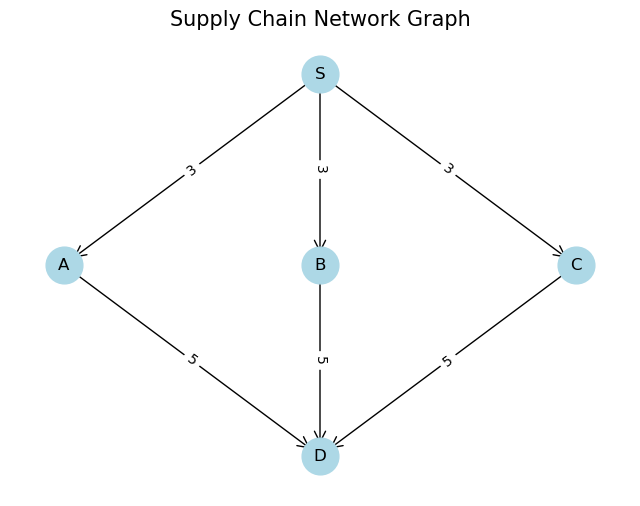

In [4]:
env.render_network()

In [5]:
from stable_baselines3.common.env_checker import check_env

check_env(env, warn=True)

**Testng the environment**

In [6]:
env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info, _ = env.step(action)
        score += reward

        env.render()

# 30, 28, 32

Episode Length: 1
Stock Level: [18.3 28.  32. ]
Planned Demand: [11.2  0.   0. ]
Actual Demand: [11.7  0.   0. ]
Action: [33.9 24.1 41.1]
Order: [0 0 0]
Reward: -262.33359973122197

Episode Length: 2
Stock Level: [18.3 20.8 20.4]
Planned Demand: [0.  7.2 9.6]
Actual Demand: [ 0.   7.2 11.6]
Action: [35.8 37.6  1.8]
Order: [0 0 0]
Reward: -448.88692731946094

Episode Length: 3
Stock Level: [18.3 11.2 20.4]
Planned Demand: [ 0.  10.2  0. ]
Actual Demand: [0.  9.6 0. ]
Action: [48.   2.1  1.5]
Order: [0 0 0]
Reward: -611.2181092458522

Episode Length: 4
Stock Level: [39.8 21.7 44.2]
Planned Demand: [ 9.5 15.9 16.1]
Actual Demand: [12.5 13.6 17.3]
Action: [29.3  0.9 30.6]
Order: [33.9 24.1 41.1]
Reward: -826.700013967268

Episode Length: 5
Stock Level: [58.1 59.3 44.1]
Planned Demand: [14.7  0.   5.3]
Actual Demand: [17.5  0.   1.9]
Action: [33.8 29.6  4.9]
Order: [35.8 37.6  1.8]
Reward: -1209.125686573489

Episode Length: 6
Stock Level: [106.   61.4  45.6]
Planned Demand: [0. 0. 0.]
Actu

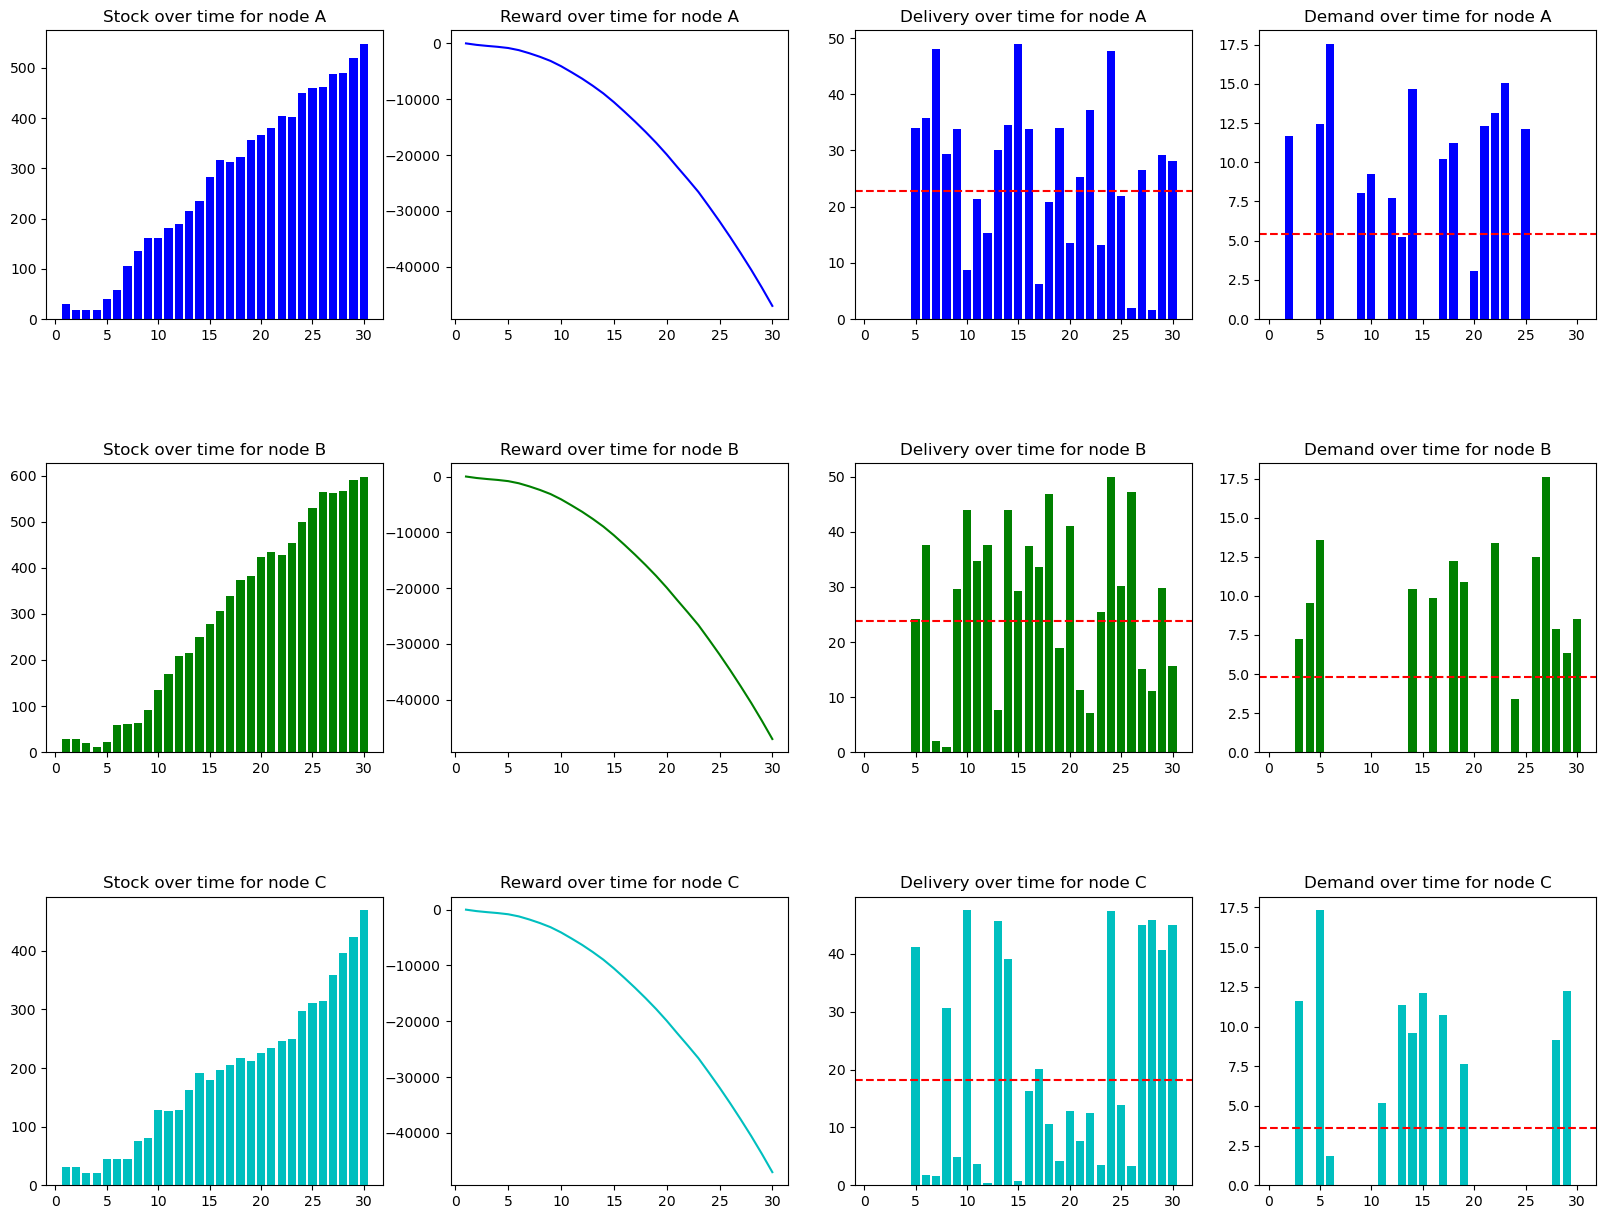

In [7]:
df = pd.read_csv('./Data/2024-10-15_13_last_environment_data.csv')
plot_data(df)

In [8]:
env.planned_demands

array([[11.166522  ,  0.        ,  0.        ],
       [ 0.        ,  7.15579513,  9.59898774],
       [ 0.        , 10.17261583,  0.        ],
       [ 9.47107832, 15.90046122, 16.08750567],
       [14.70223943,  0.        ,  5.25385965],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 9.14458959,  0.        ,  0.        ],
       [11.76995774,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  8.8012732 ],
       [10.32972806,  0.        ,  0.        ],
       [ 6.45680854,  0.        , 11.68447368],
       [14.32237404, 10.74877242, 11.50985953],
       [ 0.        ,  0.        , 12.43781252],
       [ 0.        , 10.35483748,  0.        ],
       [12.78150494,  0.        , 11.67281371],
       [14.59125756, 11.45423054,  0.        ],
       [ 0.        , 11.9232432 ,  7.80060999],
       [ 7.4702709 ,  0.        ,  0.        ],
       [14.46351056,  0.        ,  0.        ],
       [11.12170544,  7.52016535,  0.   

In [9]:
env.actual_demands

array([[11.69770606,  0.        ,  0.        ],
       [ 0.        ,  7.23221675, 11.58546457],
       [ 0.        ,  9.55644104,  0.        ],
       [12.45977932, 13.58128174, 17.3229999 ],
       [17.53755708,  0.        ,  1.87086137],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 8.02871533,  0.        ,  0.        ],
       [ 9.24864112,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  5.1954026 ],
       [ 7.72578698,  0.        ,  0.        ],
       [ 5.24104318,  0.        , 11.33766601],
       [14.64425201, 10.4561818 ,  9.57718827],
       [ 0.        ,  0.        , 12.13527586],
       [ 0.        ,  9.83698376,  0.        ],
       [10.17805802,  0.        , 10.70666026],
       [11.20934017, 12.24906709,  0.        ],
       [ 0.        , 10.88732937,  7.66659086],
       [ 3.04999146,  0.        ,  0.        ],
       [12.29851762,  0.        ,  0.        ],
       [13.15731349, 13.40936285,  0.   

**Train Model**


In [10]:
log_path = os.path.join('Training', 'Logs')
model_path = os.path.join('Training', 'Models', 'PPO')
# model_path = os.path.join('Training', 'Models', 'A2C')

In [11]:
env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

def make_env():
    # Create a new environment here
    env = SS_Mngmt_Env(network_config=network_config, EP_LENGTH=EP_LENGTH, render_mode="human")
    return env

num_envs = 8

dummy_env = DummyVecEnv([lambda: env])
# vec_env = make_vec_env(make_env, n_envs=num_envs)

model = PPO("MlpPolicy", 
            dummy_env,
            learning_rate = 0.0007,
            gamma = 0.99,
            verbose=1,
            tensorboard_log=log_path)

# model = A2C("MlpPolicy",
#             vec_env,
#             learning_rate = 0.0005,
#             gamma = 0.99,
#             verbose=1,
#             tensorboard_log=log_path)

Using cpu device


In [12]:
model.learn(total_timesteps=10000)

Logging to Training/Logs/PPO_59
-----------------------------
| time/              |      |
|    fps             | 6040 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 3179          |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 3.3181277e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.26         |
|    explained_variance   | -2.38e-07     |
|    learning_rate        | 0.0007        |
|    loss                 | 2.53e+10      |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.00018      |
|    std                  | 1             |
|    value

In [13]:
model.save(model_path)
model.load(model_path)

# evaluate_policy(model, vec_env, n_eval_episodes=10, render=True, return_episode_rewards=True)
evaluate_policy(model, dummy_env, n_eval_episodes=1, render=True, return_episode_rewards=True)

Episode Length: 1
Stock Level: [30.  28.  20.2]
Planned Demand: [ 0.   0.  13.4]
Actual Demand: [ 0.   0.  11.8]
Action: [24.9 24.9 25.1]
Order: [0 0 0]
Reward: -237.66157969406618

Episode Length: 2
Stock Level: [30. 28.  9.]
Planned Demand: [ 0.   0.  12.3]
Actual Demand: [ 0.   0.  11.1]
Action: [24.9 24.9 25.1]
Order: [0 0 0]
Reward: -454.35195228113867

Episode Length: 3
Stock Level: [30.  28.   2.4]
Planned Demand: [0.  0.  8.8]
Actual Demand: [0.  0.  6.7]
Action: [24.9 24.9 25.1]
Order: [0 0 0]
Reward: -666.674846592987

Episode Length: 4
Stock Level: [54.9 39.3 23.8]
Planned Demand: [0.  8.6 4. ]
Actual Demand: [ 0.  13.7  3.7]
Action: [24.9 24.9 25.1]
Order: [24.9 24.9 25.1]
Reward: -972.8478845426082

Episode Length: 5
Stock Level: [71.9 64.2 48.9]
Planned Demand: [8.4 0.  0. ]
Actual Demand: [7.9 0.  0. ]
Action: [24.9 24.9 25.1]
Order: [24.9 24.9 25.1]
Reward: -1431.8711325612437

Episode Length: 6
Stock Level: [91.8 81.6 60.2]
Planned Demand: [ 6.8  8.4 13. ]
Actual Deman

/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


([-521034.7787322998], [30])

In [14]:
file = './Data/2024-10-15_13_last_environment_data.csv'
df = pd.read_csv(file)

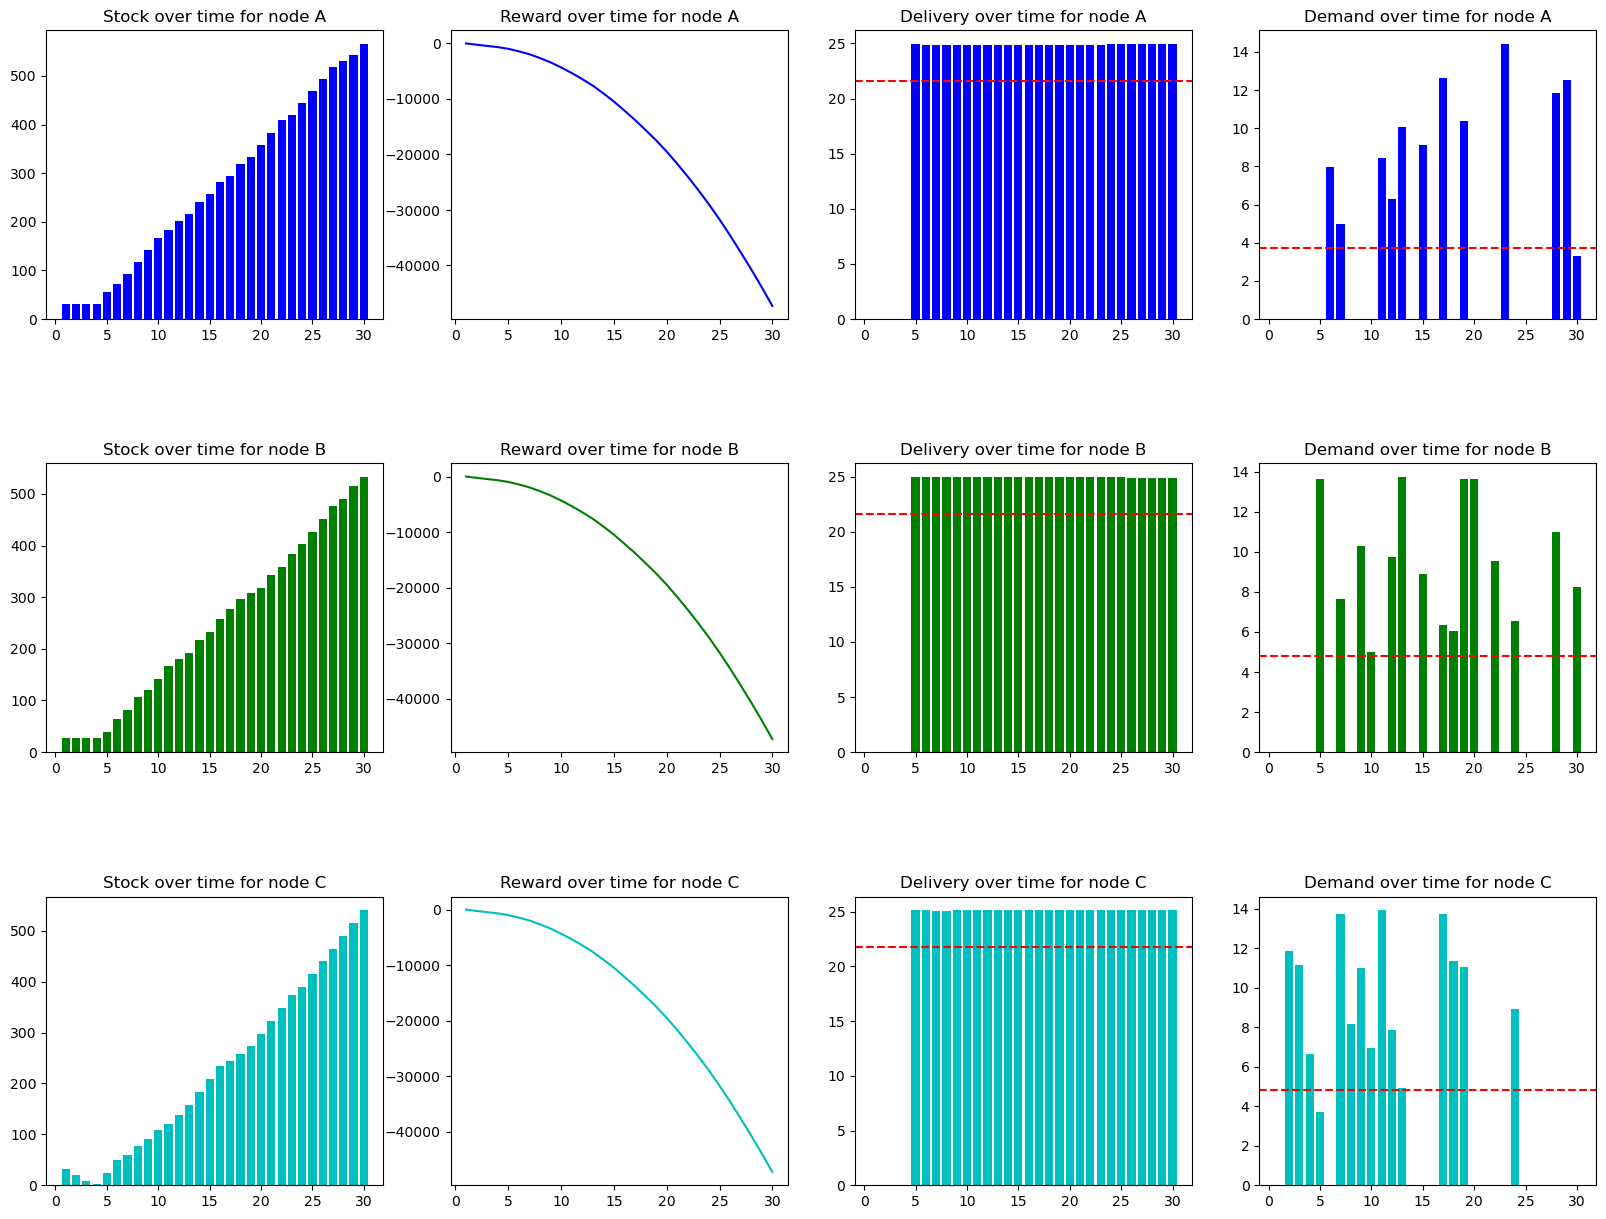

In [15]:
plot_data(df)